In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from hrixs_data import HrixsData
from reflectivity import (
    MaterialManager,
    create_ml_model,
    load_sample,
    reflectivity_parrat,
    theta_exp,
)

from scipy.optimize import curve_fit

Cupy is not installed in this environment, no access to the GPU


In [2]:
MaterialManager.add_material("B4C", {"B": 4, "C": 1})
MaterialManager.add_material("Cu", {"Cu": 1})
MaterialManager.add_material("SiC", {"Si": 1, "C": 1})

sample_data = load_sample("M-220706E1_Z_2")
mlm = create_ml_model(sample_data)
mlm.set_multilayer_repetitions("body", 15)
mlm.get_sub_multilayer("body").get_layer("Cu").use_ERES = True

In [5]:
hd = HrixsData.get_run(214)

# Used to reduce the data size
def filter_energies(da):
    return da.where(
        (da.energy >= 910) & (da.energy <= 990),
        drop = True
    )

# Used as a startng value. Precomputed, as it takes a while to calculate.
normalization = float((max(hd.beam_spectrum) * max(np.abs(reflectivity_parrat(filter_energies(hd.ds).energy.data, mlm, theta_exp))**2)).values)

## Fitting routines
Routines to be used for fitting. Modular and can be expanded by specifying each entry.

In [55]:
routines = {}
fel_max_offset = 10

# The scaling has to be the first parameter, as it still needs to be
# multiplied by the maximum of the spectrum (see next section)

# Fits cold runs
def reflectivity_fitting_angle(energy_eV, scaling, fel_energy_offset, theta_2):
    refl = np.abs(reflectivity_parrat(energy_eV, mlm, theta_2 / 2)) ** 2
    return refl * hd.get_beam_spectrum_offset(fel_energy_offset, energy_eV) * scaling

routines["angle"] = {
    "fit_function": reflectivity_fitting_angle,
    "start_vals": [1/normalization, 0, 2*theta_exp],
    "bounds_low": [0, -fel_max_offset, 2*theta_exp - 1],
    "bounds_high": [np.inf, fel_max_offset, 2*theta_exp + 1],
    "parameters": ["Scaling", "FEL energy offset", r"$2\theta$"],
    "parameter_units": ["a.U.", "eV", "°"],
}


# Also fits ERES parameters. Removed 2 theta (theta_2), as it seems not necessary here.
def reflectivity_fitting_eres(energy_eV, scaling, fel_offset, f_eres, gamma2):
    theta = 34
    refl = np.abs(reflectivity_parrat(energy_eV, mlm, theta, f_eres, gamma2)) ** 2
    return refl * hd.get_beam_spectrum_offset(fel_offset, energy_eV) * scaling

routines["eres"] = {
    "fit_function": reflectivity_fitting_eres,
    "start_vals": [1/normalization, 0, 1, 1],
    "bounds_low": [0, -fel_max_offset, 0, 0],
    "bounds_high": [np.inf, fel_max_offset, np.inf, np.inf],
    "parameters": ["Scaling", "FEL energy offset", r"$f_{ERES}$", r"$\frac{\gamma}{2}$"],
    "parameter_units": ["a.U.", "eV", "1", "1"]
}

In [48]:
routine = "eres"
routines[routine]

{'fit_function': <function __main__.reflectivity_fitting_eres(energy_eV, scaling, fel_offset, f_eres, gamma2)>,
 'start_vals': [5960.948727181874, 0, 1, 1],
 'bounds_low': [0, -10, 0, 0],
 'bounds_high': [inf, 10, inf, inf],
 'parameters': ['Scaling',
  'FEL energy offset',
  '$f_{ERES}$',
  '$\\frac{\\gamma}{2}$'],
 'parameter_units': ['a.U.', 'eV', '1', '1']}

## Fitting

In [52]:
spectrum = filter_energies(hd.get_spectrum())

# Copy needed to not modify the original values
start_vals = routines[routine]["start_vals"].copy()
start_vals[0] *= max(spectrum)

popt, pcov = curve_fit(
    routines[routine]["fit_function"],
    spectrum.energy.data,
    spectrum.data,
    start_vals,
    bounds=(
        routines[routine]["bounds_low"],
        routines[routine]["bounds_high"],
    ),
)

(925.0, 940.0)

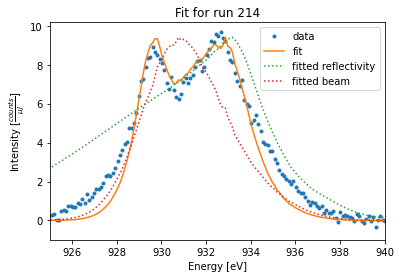

In [53]:
fitted = routines[routine]["fit_function"](spectrum.energy.data, *popt)
no_beam = np.abs(reflectivity_parrat(spectrum.energy.data, mlm, theta_exp))**2
beam_spectrum = hd.get_beam_spectrum_offset(popt[1], spectrum.energy.data)

plt.figure()
plt.plot(spectrum.energy, spectrum, ".", label="data")
plt.plot(spectrum.energy, fitted, label="fit")
plt.plot(spectrum.energy, no_beam * max(fitted) / max(no_beam), ":", label="fitted reflectivity")
plt.plot(spectrum.energy, beam_spectrum * max(fitted) / max(beam_spectrum), ":", label="fitted beam")
plt.xlabel("Energy [eV]")
plt.ylabel(r"Intensity [$\frac{counts}{\mu J}$]")
plt.title(f"Fit for run {hd.run_number}")
plt.legend()
plt.xlim(925, 940)

Fit results:
------------------------------
Scaling: 57609 +- 404.51
FEL energy offset: 4.775 +- 0.019107
$f_{ERES}$: 7.84 +- 0.24002
$\frac{\gamma}{2}$: 0.77247 +- 0.033707



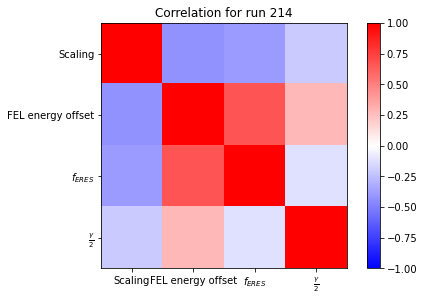

In [54]:
# Fitting results and correlation plot

pcor = pcov.copy()
for i in range(pcor.shape[0]):
    for j in range(pcor.shape[1]):
        pcor[i, j] /= np.sqrt(pcov[i, i] * pcov[j, j])

plt.figure()
plt.imshow(pcor, cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.tight_layout()
plt.title(f"Correlation for run {hd.run_number}")
plt.xticks(range(len(routines[routine]["parameters"])), routines[routine]["parameters"])
plt.yticks(range(len(routines[routine]["parameters"])), routines[routine]["parameters"])

print("Fit results:")
print("-"*30)
for i, (po, pn) in enumerate(zip(popt, routines[routine]["parameters"])):
    print(f"{pn}: {po:.5g} +- {np.sqrt(pcov[i, i]):.5g}")
print()